In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import yfinance as yf
from datetime import date, datetime, timedelta


sns.set_style("darkgrid")

In [2]:
ticker = "CL=F"
interval = "1d"
start_date = datetime.strptime("2017-01-01", "%Y-%m-%d")
end_date = datetime.strptime("2023-02-14", "%Y-%m-%d")
# end_date = date.today()

# WTI Crude.
raw_df = yf.download(ticker, start=start_date.strftime("%Y-%m-%d"), end=end_date.strftime("%Y-%m-%d"), interval=interval)


df = pd.DataFrame()
df["price"] = raw_df[["Adj Close"]]
df["day_of_week"] = df.index.day_of_week
df["day_of_month"] = df.index.day

df["roll_date"] = False

df.shape

[*********************100%***********************]  1 of 1 completed


(1542, 4)

In [3]:
df.index.day.values

array([ 3,  4,  5, ...,  9, 10, 13])

In [4]:
def roll_date_wti_oil(month_df):

    days = month_df["day_of_month"].values

    # Last trade is 4 business days before 25th if 25th is a Bday, else 5 business days before.
    expiry = 25
    last_trade = 21 if expiry in days else 20

    # Account for `last_trade` being on a weekend too.
    index = []
    while len(index) == 0:
        # index = month_df.index[month_df["day_of_month"] == last_trade]
        index = month_df.index[month_df.index.day == last_trade]
        last_trade -= 1
        
        assert last_trade > 0
    
    month_df.loc[index.strftime("%Y-%m-%d"), "roll_date"] = True
        
    return month_df

In [5]:
dfg = df.groupby(by=[df.index.month, df.index.year])
dfg = dfg.apply(roll_date_wti_oil)

dfg[["roll_date"]].astype(int).sum() / 12

/var/folders/2v/xw5v0n3d5rlf442fyyzb04dc0000gn/T/ipykernel_1572/835471125.py:2: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  dfg = dfg.apply(roll_date_wti_oil)


roll_date    6.166667
dtype: float64

<AxesSubplot: >

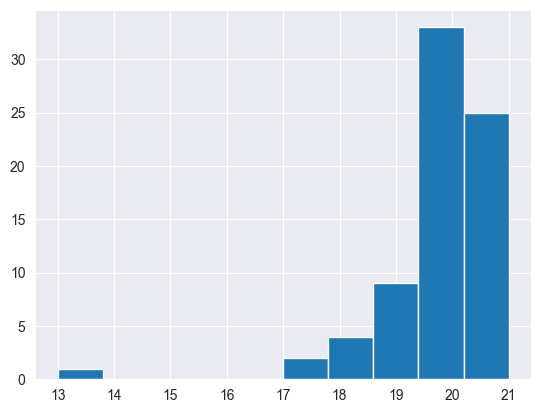

In [6]:
# dfg[["roll_date"]].astype(int).plot()
dfg[dfg["roll_date"]]["day_of_month"].hist()

In [7]:
dfg[dfg["roll_date"]]["day_of_month"] == 13

Date
2017-01-20    False
2017-02-17    False
2017-03-20    False
2017-04-21    False
2017-05-19    False
              ...  
2022-10-21    False
2022-11-21    False
2022-12-20    False
2023-01-20    False
2023-02-13     True
Name: day_of_month, Length: 74, dtype: bool

In [8]:
# It is the last day in the dataset...
dfg.query("roll_date and day_of_month == 13")

,price,day_of_week,day_of_month,roll_date
Date,,,,
2023-02-13,80.139999,0,13,True
